# Access Database-Files to explore and summerise Data

In [26]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [27]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [28]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-06-24/data_eval_new/"
file_name = "int_norm_20160424_bgd_new_In_corr.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [29]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [30]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [31]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

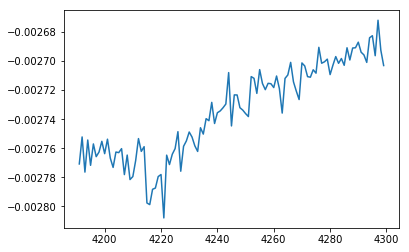

In [32]:
# Check Baselines
column = "117"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

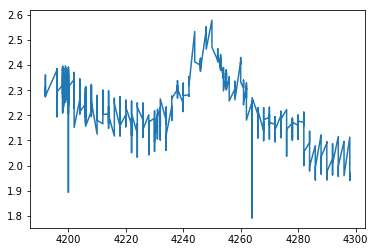

In [33]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

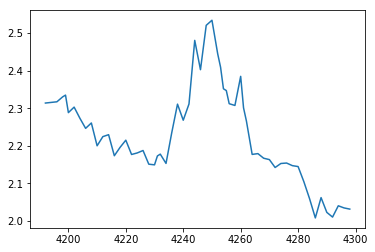

In [34]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

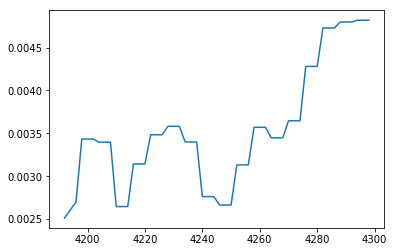

In [35]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [36]:
background_mean = df_mean(background)

# Outlier rejection

In [37]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_116_120"
interf_corr = "Te125_Xe129_corr"

In [38]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [41]:
column = "124/120"
sample = "NIST 200ppb"

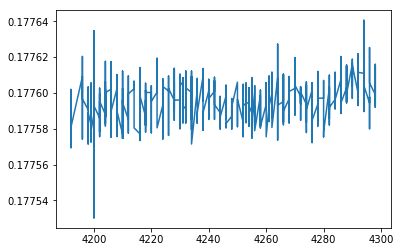

In [42]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [43]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [44]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2016-06-24 11:14:00,NIST 200ppb,2,1,4192,0.029823,NaN,0.010427,NaN,0.235305,0.743031,0.263479,0.142091,0.177582
2016-06-24 11:14:00,NIST 200ppb,2,2,4192,0.029824,0.020193,0.010317,NaN,0.235314,0.743030,0.263463,0.142085,0.177575
2016-06-24 11:14:00,NIST 200ppb,2,3,4192,0.029815,0.020187,0.010319,NaN,0.235306,0.743024,0.263470,0.142100,0.177595
2016-06-24 11:14:00,NIST 200ppb,2,4,4192,0.029819,0.020191,0.010322,0.446,0.235313,0.743019,0.263468,0.142092,0.177596
2016-06-24 11:14:00,NIST 200ppb,2,5,4192,0.029821,0.020191,0.010190,0.446,0.235307,0.743032,0.263469,0.142088,0.177569
2016-06-24 11:14:00,NIST 200ppb,2,6,4192,0.029816,0.020190,NaN,0.446,0.235309,0.743014,0.263474,0.142109,0.177602
2016-06-24 11:14:00,NIST 200ppb,2,7,4192,0.029821,0.020188,0.010328,0.446,0.235314,0.743016,0.263479,0.142099,0.177599
2016-06-24 11:14:00,NIST 200ppb,2,8,4192,0.029817,0.020187,0.010297,NaN,0.235308,0.743033,0.263477,0.142094,0.177588
2016-06-24 11:14:00,NIST 200ppb,2,9,4192,0.029817,0.020190,0.010285,NaN,0.235310,0.743019,0.263479,0.142095,0.177598


In [45]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
4198        2016-06-24 12:26:00    0.187277
4201        2016-06-24 13:07:00    0.187198
            2016-06-24 13:07:00    0.187198
4219        2016-06-24 17:02:00    0.187428
4222        2016-06-24 17:41:00    0.187368
4223        2016-06-24 17:55:00    0.187380
4237        2016-06-24 21:01:00    0.187696
4243        2016-06-24 22:21:00    0.187507
            2016-06-24 22:21:00    0.187241
4254        2016-06-25 01:16:00    0.187263
4289        2016-06-25 09:02:00    0.187674
            2016-06-25 09:02:00    0.187676
            2016-06-25 09:02:00    0.187676
4294        2016-06-25 10:07:00    0.187731
4296        2016-06-25 10:34:00    0.187656
            2016-06-25 10:34:00    0.187658
Name: 124/120, dtype: float64

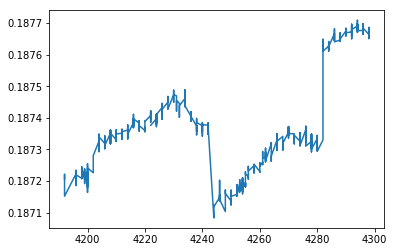

In [46]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [47]:
df[df["Sample"] == sample][column].std()

0.00015260152724770468

In [48]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

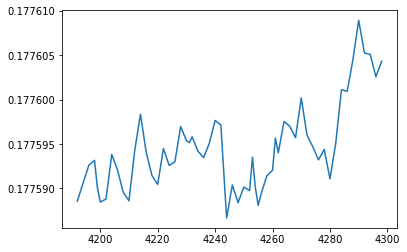

In [49]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [50]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,
2016-06-24 11:14:00,4192,NIST 200ppb,0.029818,0.020188,0.010292,0.446,0.235310,0.743016,0.263474,0.142095,0.177589
2016-06-24 11:38:00,4194,NIST 350ppb,0.029817,0.020187,0.010284,0.446,0.235309,0.743009,0.263478,0.142100,0.177597
2016-06-24 12:02:00,4196,NIST 200ppb,0.029821,0.020190,0.010310,0.446,0.235308,0.742994,0.263472,0.142099,0.177593
2016-06-24 12:26:00,4198,NIST 200ppb,0.029818,0.020191,0.010286,0.446,0.235308,0.742998,0.263473,0.142098,0.177593
2016-06-24 12:40:00,4199,NIST 200ppb,0.029819,0.020191,0.010293,0.446,0.235308,0.742994,0.263472,0.142097,0.177590
2016-06-24 12:53:00,4200,NIST 200ppb,0.029822,0.020192,0.010279,0.446,0.235306,0.742990,0.263470,0.142097,0.177588
2016-06-24 13:07:00,4201,NIST 350ppb,0.029821,0.020190,0.010298,0.446,0.235308,0.742989,0.263472,0.142099,0.177590
2016-06-24 13:20:00,4202,NIST 200ppb,0.029821,0.020190,0.010288,0.446,0.235307,0.742981,0.263469,0.142096,0.177589
2016-06-24 13:44:00,4204,NIST 200ppb,0.029821,0.020189,0.010263,0.446,0.235307,0.742979,0.263467,0.142096,0.177594


In [51]:
date_list = []
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [52]:
drop_sum = [pd.Timestamp('2016-06-24 11:14:00'), 
             pd.Timestamp('2016-06-24 11:38:00'), 
             pd.Timestamp('2016-06-24 12:26:00'),
             pd.Timestamp('2016-06-24 12:40:00'),
             pd.Timestamp('2016-06-24 19:26:00')]

In [53]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

/Users/marf/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/marf/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/marf/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [54]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [55]:
data_mean_int_sum

112/120                       114/120  \
                               mean           SD2 count      mean   
Sample                                                              
Allende HP 1_1             0.029823           NaN     1  0.020195   
Allende HP 1_2             0.029822           NaN     1  0.020195   
Allende bomb 1_2           0.029823           NaN     1  0.020199   
NIST 200ppb                0.029823  4.606128e-06    54  0.020192   
NIST 200ppb + 0.001ppb In  0.029822  3.804514e-06     2  0.020191   
NIST 200ppb + 0.005ppb U   0.029824  1.706558e-06     2  0.020193   
NIST 200ppb + 0.010ppb Cd  0.029826           NaN     1  0.020196   
NIST 200ppb + 0.015ppb U   0.029831           NaN     1  0.020198   
NIST 200ppb + 0.03ppb Cd   0.029823  7.771961e-07     2  0.020194   
NIST 200ppb + 0.056ppb Zr  0.029826  3.779965e-06     2  0.020193   
NIST 200ppb + 0.082ppb Rh  0.029824  6.288073e-06     2  0.020193   
NIST 200ppb + 0.109ppb Ru  0.029820  1.875483e-06     2  0.020190   
NIST 200ppb + 0.250ppb Pd  0.029823  5.713604e-06     2  0.020193   
NIST 200ppb + 0.440ppb Mo  0.029822  4.799074e-06     2  0.020192   
NIST 200ppb + ME           0.029823  8.386645e-06     2  0.020193   
NIST 350ppb                0.029824  8.792498e-06     2  0.020192   
ZH09-05 23.3_1_3           0.029822           NaN     1  0.020194   
ZH09-05 23.3_1_5           0.029824           NaN     1  0.020195   
ZH09-05 23.3_1_5 new       0.029823           NaN     1  0.020193   
ZH09-05_23.3_1_4           0.029822           NaN     1  0.020191   

                                                115/120                  \
                                    SD2 count      mean       SD2 count   
Sample                                                                    
Allende HP 1_1                      NaN     1  0.010156       NaN     1   
Allende HP 1_2                      NaN     1  0.009347       NaN     1   
Allende bomb 1_2                    NaN     1  0.009155       NaN     1   
NIST 200ppb                3.947693e-06    54  0.010297  0.000042    54   
NIST 200ppb + 0.001ppb In  5.096247e-07     2  0.010297  0.000055     2   
NIST 200ppb + 0.005ppb U   4.131688e-07     2  0.010305  0.000049     2   
NIST 200ppb + 0.010ppb Cd           NaN     1  0.009963       NaN     1   
NIST 200ppb + 0.015ppb U            NaN     1  0.010301       NaN     1   
NIST 200ppb + 0.03ppb Cd   6.111508e-07     2  0.009285  0.000024     2   
NIST 200ppb + 0.056ppb Zr  3.074461e-08     2  0.010323  0.000118     2   
NIST 200ppb + 0.082ppb Rh  5.693421e-06     2  0.010293  0.000049     2   
NIST 200ppb + 0.109ppb Ru  6.795912e-06     2  0.010311  0.000052     2   
NIST 200ppb + 0.250ppb Pd  2.325210e-06     2  0.010311  0.000062     2   
NIST 200ppb + 0.440ppb Mo  3.639714e-06     2  0.010308  0.000012     2   
NIST 200ppb + ME           4.061364e-06     2  0.009956  0.000015     2   
NIST 350ppb                3.462780e-06     2  0.010291  0.000019     2   
ZH09-05 23.3_1_3                    NaN     1  0.010044       NaN     1   
ZH09-05 23.3_1_5                    NaN     1  0.010145       NaN     1   
ZH09-05 23.3_1_5 new                NaN     1  0.010126       NaN     1   
ZH09-05_23.3_1_4                    NaN     1  0.010213       NaN     1   

                          116/120  ...  118/120   119/120                      \
                             mean  ...    count      mean           SD2 count   
Sample                             ...                                          
Allende HP 1_1              0.446  ...        1  0.263478           NaN     1   
Allende HP 1_2              0.446  ...        1  0.263475           NaN     1   
Allende bomb 1_2            0.446  ...        1  0.263475           NaN     1   
NIST 200ppb                 0.446  ...       54  0.263469  5.610614e-06    54   
NIST 200ppb + 0.001ppb In   0.446  ...        2  0.263469  2.314890e-06     2   
NIST 200ppb + 0.005ppb U    0.446  ...        2  0.263474  2.37412

In [56]:
date_list = [pd.Timestamp('2016-06-24 15:57:00'),
             pd.Timestamp('2016-06-24 19:26:00'), 
             pd.Timestamp('2016-06-24 22:53:00')]


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [57]:

date_list = [pd.Timestamp('2016-06-24 12:02:00'),
             pd.Timestamp('2016-06-24 12:26:00'),
             pd.Timestamp('2016-06-24 23:16:00')]

epsilon_int_200 = epsilon_int_200.drop(date_list)
delta_raw_200 = delta_raw_200.drop(date_list)

In [58]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -10) & (df["Filenumber"] <= 10)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [59]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
epsilon_int_200

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2016-06-24 11:38:00,4194,-0.832504,-0.927776,-16.334046,-1.110223e-12,0.005183,0.053010,0.204523,0.244209,0.368115,NIST 350ppb
2016-06-24 12:40:00,4199,-0.253518,-0.398405,10.625364,2.220446e-12,0.039799,0.011090,0.050209,-0.019593,-0.040445,NIST 200ppb
2016-06-24 12:53:00,4200,0.771217,0.920110,-11.553443,-1.110223e-12,-0.039064,0.026077,-0.042575,0.016358,-0.054824,NIST 200ppb
2016-06-24 13:07:00,4201,-0.278689,-0.383801,14.452745,0.000000e+00,0.073242,0.049191,0.115994,0.176690,0.055628,NIST 350ppb
2016-06-24 13:20:00,4202,-0.286729,-0.352974,16.667370,2.220446e-12,-0.007350,-0.045806,0.023870,-0.048398,-0.132085,NIST 200ppb
2016-06-24 13:44:00,4204,-0.391675,-0.883125,-28.713071,-1.110223e-12,0.008451,0.020858,-0.055745,-0.057816,0.190195,NIST 200ppb
2016-06-24 13:58:00,4205,-0.502052,0.129451,31.615245,2.220446e-12,0.003451,0.083705,0.192995,0.226452,0.097647,NIST 200ppb + 0.440ppb Mo
2016-06-24 14:11:00,4206,0.545959,0.923143,3.129056,-1.110223e-12,-0.039897,-0.040814,0.023585,0.173861,0.021532,NIST 200ppb
2016-06-24 14:25:00,4207,-0.617283,-0.068344,21.456776,0.000000e+00,0.027881,0.028717,0.019789,0.204289,-0.020659,NIST 200ppb + 0.250ppb Pd


In [61]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [62]:
epsilon_sum_all

112/120              114/120                115/120  \
                             mean    SD2 count    mean    SD2 count      mean   
Sample                                                                          
Allende HP 1_1             -0.398    NaN     1   0.852    NaN     1  -152.300   
Allende HP 1_2             -0.557    NaN     1   0.601    NaN     1  -927.189   
Allende bomb 1_2           -0.107    NaN     1   1.939    NaN     1 -1095.549   
NIST 200ppb                 0.004  0.924    50   0.023  1.391    50    -0.417   
NIST 200ppb + 0.001ppb In   0.386  1.727     2   0.425  1.770     2    15.658   
NIST 200ppb + 0.005ppb U    0.508  0.002     2   0.597  0.632     2    15.539   
NIST 200ppb + 0.010ppb Cd  -0.267    NaN     1  -0.169    NaN     1  -346.234   
NIST 200ppb + 0.015ppb U    0.726    NaN     1   0.691    NaN     1    12.681   
NIST 200ppb + 0.03ppb Cd    0.560  0.559     2   1.169  1.657     2  -992.164   
NIST 200ppb + 0.056ppb Zr   0.763  0.055     2   0.630  0.562     2     0.201   
NIST 200ppb + 0.082ppb Rh   0.202  0.673     2   0.670  1.748     2   -13.154   
NIST 200ppb + 0.109ppb Ru  -0.183  0.224     2  -0.396  2.000     2    17.715   
NIST 200ppb + 0.250ppb Pd   0.061  1.919     2   0.488  1.573     2    10.833   
NIST 200ppb + 0.440ppb Mo   0.046  1.551     2   0.647  1.463     2    18.712   
NIST 200ppb + ME           -0.404  0.211     2  -0.144  0.776     2  -345.669   
NIST 350ppb                -0.481  0.611     3  -0.775  0.683     3     2.680   
ZH09-05 23.3_1_3           -0.451    NaN     1   0.605    NaN     1  -242.232   
ZH09-05 23.3_1_5            0.093    NaN     1   0.846    NaN     1  -159.683   
ZH09-05 23.3_1_5 new       -0.682    NaN     1  -0.504    NaN     1  -162.491   
ZH09-05_23.3_1_4           -0.306    NaN     1  -1.096    NaN     1   -88.176   

                                        116/120  ...  118/120 119/120         \
                              SD2 count    mean  ...    count    mean    SD2   
Sample                                           ...                           
Allende HP 1_1                NaN     1    -0.0  ...        1   0.189    NaN   
Allende HP 1_2                NaN     1    -0.0  ...        1   0.099    NaN   
Allende bomb 1_2              NaN     1     0.0  ...        1   0.088    NaN   
NIST 200ppb                39.614    50     0.0  ...       50  -0.000  0.142   
NIST 200ppb + 0.001ppb In   5.620     2    -0.0  ...        2   0.036  0.053   
NIST 200ppb + 0.005ppb U   68.600     2    -0.0  ...        2   0.162  0.043   
NIST 200ppb + 0.010ppb Cd     NaN     1     0.0  ...        1  -0.013    NaN   
NIST 200ppb + 0.015ppb U      NaN     1     0.0  ...        1   0.161    NaN   
NIST 200ppb + 0.03ppb Cd    5.705     2    -0.0  ...        2   0.015  0.089   
NIST 200ppb + 0.056ppb Zr  37.509     2    -0.0  ...        2   0.034  0.209   
NIST 200ppb + 0.082ppb Rh   1.589     2     0.0  ...        2   0.013  0.289   
NIST 200ppb + 0.109ppb Ru  16.980     2    -0.0  ...        2   0.134  0.038   
NIST 200ppb + 0.250ppb Pd  30.048     2     0.0  ...        2  -0.007  0.077   
NIST 200ppb + 0.440ppb Mo  36.496     2     0.0  ...        2   0.134  0.167   
NIST 200ppb + ME           20.842     2     0.0  ...        2   0.137  0.041   
NIST 350ppb                33.243     3     0.0  ...        3   0.035  0.441   
ZH09-05 23.3_1_3              NaN     1     0.0  ...        1   0.199    NaN   
ZH09-05 23.3_1_5              NaN     1     0.0  ...        1   0.008    NaN   
ZH09-05 23.3_1_5 new          NaN     1    -0.0  ...        1   0.010    NaN   
ZH09-05_23.3_1_4              NaN     1     0.0  ...        1   0.063    NaN   

                                122/120              124/120               
                          count    mean    SD2 count    mean    SD2 count  
Sample                                                                     
Allende HP 1_1                1   0.239    NaN     1   0.037    NaN     1  
Allende HP 1_2   

In [192]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [91]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [92]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [193]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [194]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [195]:
writer_orig.save()

In [199]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [25]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')